In [1]:
import pandas as pd
from pybliometrics.scopus import ScopusSearch, AbstractRetrieval, AuthorRetrieval, ContentAffiliationRetrieval
import networkx as nx

nodes=pd.DataFrame()
edges=[]
gen={}
htc = "10.1257/aer.20140850"

shleifer1 = "10.1257/jel.46.2.285" #economicconsequences
shleifer2 = "10.1257/jep.28.3.109" #informalityanddevelopment
shleifer3 = "10.1016/j.jfineco.2018.04.007" #extrapolationandbubbles
ab = AbstractRetrieval(shleifer3, view="FULL")


We begin by adding all of the papers which Paper 0 cites.

In [2]:
nodes=pd.DataFrame()
nodes = nodes.append({"id":"", "title": ab.title, "sourcetitle": ab.sourcetitle_abbreviation, "publicationyear": ab.coverDate[0:4], "eid": ab.eid, "gen": '0' }, ignore_index=True)
ref_df = pd.DataFrame(ab.references)
ref_df["eid"] = '2-s2.0-' + ref_df['id']
ref_df['gen'] = '-1'

ref_df2 = pd.concat([ref_df['eid'], ref_df['id'], ref_df['publicationyear'], ref_df['sourcetitle'], ref_df['title'], ref_df['gen']], axis=1, keys=['eid', 'id', 'publicationyear', 'sourcetitle', 'title', 'gen'], sort=True)
#ref_df2 = ref_df2.drop(18)
nodes = nodes.append(ref_df2, ignore_index = True, sort=True)

for row in ref_df2.itertuples():
    edges.append((row.eid, ab.eid))

len(nodes)

44

Then, we add all of the papers which cite Paper 0.

In [15]:
s = ScopusSearch(ab.eid) 
for x in s.results:
    if(x.eid not in list(nodes['eid'])):
        nodes = nodes.append({"id":"", "title": x.title, "sourcetitle": "", "publicationyear": x.coverDate[0:4], "eid": x.eid, "gen": '1' }, ignore_index=True)
    edges.append((ab.eid, x.eid))

print(len(nodes)) 

61


Then, we add all of the papers which the papers cited by paper 0 have themselves cited. (Generation -2)

In [16]:
for y in ab.references:
    refs = AbstractRetrieval(y.id, view="FULL")
    if(refs.references != None):
        ref_df = pd.DataFrame(refs.references)
        ref_df["eid"] = '2-s2.0-' + ref_df['id']
        ref_df['gen'] = '-2'
        ref_df2 = pd.concat([ref_df['eid'], ref_df['id'], ref_df['publicationyear'], ref_df['sourcetitle'], ref_df['title'], ref_df['gen']], axis=1, keys=['eid', 'id', 'publicationyear', 'sourcetitle', 'title', 'gen'])
        
        for row in ref_df2.itertuples():
            edges.append((row.eid, '2-s2.0-' + y.id))
            if(row.eid not in list(nodes['eid'])):
                nodes = nodes.append({"id":row.id, "title": row.title, "sourcetitle": row.sourcetitle, "publicationyear": row.publicationyear, "eid": row.eid, "gen": '-2' }, ignore_index=True)
                     

len(nodes)

1205

And the papers which Generation 1 papers cite.

In [17]:
for x in s.results:
    s = AbstractRetrieval(x.eid, view="FULL")
    if(s.references != None):
        ref_df = pd.DataFrame(s.references)
        ref_df['eid'] = '2-s2.0-'+ ref_df['id']
        ref_df['gen'] = '9'
        ref_df2 = pd.concat([ref_df['eid'], ref_df['id'], ref_df['publicationyear'], ref_df['sourcetitle'], ref_df['title'], ref_df['gen']], axis=1, keys=['eid', 'id', 'publicationyear', 'sourcetitle', 'title', 'gen'])
        
        for row in ref_df2.itertuples():
            if(row.eid not in list(nodes['eid'])):
                nodes = nodes.append({"id": row.id, "title": row.title, "sourcetitle": row.sourcetitle, "publicationyear": row.publicationyear, "eid": row.eid, "gen": row.gen }, ignore_index=True)
            edges.append((row.eid, x.eid))
    
print(len(nodes))

1766


We also add the papers which have cited the papers that Paper 0 cites.

In [18]:
for y in ab.references:
    search = ScopusSearch(y.id)
    for x in search.results:
        edges.append(('2-s2.0-' + y.id, x.eid))
        if(x.eid not in list(nodes['eid'])):
            nodes = nodes.append({"id":"", "title": x.title, "sourcetitle": "", "publicationyear": x.coverDate[0:4], "eid": x.eid, "gen": "9"}, ignore_index = True)


In [19]:
s = ScopusSearch(ab.eid) 
        
for x in s.results:
    s = ScopusSearch(x.eid)
    if (s.results != None):
        for z in s.results:
            edges.append((x.eid, z.eid))
            if(z.eid not in list(nodes['eid'])):
                nodes = nodes.append({"id":"", "title": z.title, "sourcetitle": "", "publicationyear": z.coverDate[0:4], "eid": z.eid, "gen": "2"}, ignore_index = True)
            
len(nodes)         


13054

In [88]:
import matplotlib.pyplot as plt # Version 3.0.3
import numpy as np

node_names = nodes['eid']   
gen = nodes.set_index('eid')['gen'].to_dict()
publicationyear = nodes.set_index('eid')['publicationyear'].to_dict()

G = nx.DiGraph()
G.add_nodes_from(node_names)
G.add_edges_from(edges)
nx.set_node_attributes(G, gen, "gen")

pos=nx.circular_layout(G) # positions for all nodes

cols = [v for v in gen.values()]
cols = ["red" if x=='0' else x for x in cols]
cols = ["darkorange" if x=='-1' else x for x in cols]
cols = ["aqua" if x=='1' else x for x in cols]
cols = ["cornflowerblue" if x=='-2' else x for x in cols]
cols = ["blue" if x=="" else x for x in cols]

    


In [105]:
nodes.to_excel("nodes_Example3.xlsx")

In [23]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['gen'] == '0' or v['gen'] == '-1']  

len(selected_nodes)

44

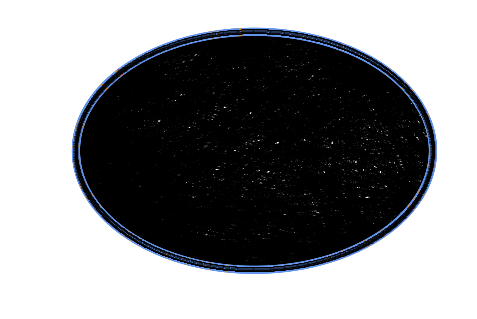

In [89]:
selected_nodes = [n for n,v in G.nodes(data=True) if v['gen'] == '0' or v['gen'] == '-1' or v['gen'] == '-2']  
G2 = G.subgraph(selected_nodes)
pos=nx.circular_layout(G2) # positions for all nodes
# pos = {key:value for key,value in pos.items() if key in selected_nodes}
labels=dict((n,d['gen']) for n,d in G2.nodes(data=True))

cols = [v for v in labels.values()]
cols = ["red" if x=='0' else x for x in cols]
cols = ["darkorange" if x=='-1' else x for x in cols]
# cols = ["aqua" if x=='1' else x for x in cols]
cols = ["cornflowerblue" if x=='-2' else x for x in cols]
cols = ["blue" if x=="" else x for x in cols]

nx.draw_circular(G2, node_size = 50, node_color = cols) #, node_size = sizes)
nx.draw_networkx_labels(G2,pos, labels, font_size=7)
plt.savefig('network3.pdf', bbox_inches='tight', figsize=(50, 50))




In [26]:
list(nx.isolates(G)) 

[]

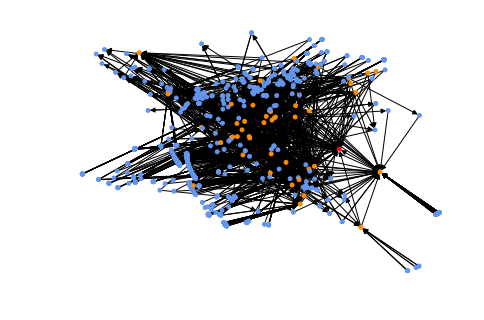

In [45]:
pos=nx.kamada_kawai_layout(G2) # positions for all nodes

nx.draw_kamada_kawai(G2, node_size = 15, node_color=cols)
#nx.draw_networkx_labels(G2,pos, labels, font_size=7)

plt.savefig('network3-1.pdf', bbox_inches='tight', figsize=(50, 50))



Compare: Katz, in-degree, PageRank, eigenvector centrality

In [28]:
all_indegree = nx.in_degree_centrality(G)
all_katz = nx.katz_centrality(G)
all_eigens = nx.eigenvector_centrality(G)
all_pagerank = nx.pagerank(G)
katz = {key:value for key,value in all_katz.items() if key in selected_nodes}
indegree = {key:value for key,value in all_indegree.items() if key in selected_nodes}
eigens = {key:value for key,value in all_eigens.items() if key in selected_nodes}
pagerank = {key:value for key,value in all_pagerank.items() if key in selected_nodes}

In [29]:
gen1 = [n for n,v in G.nodes(data=True) if v['gen'] == '-1']  
gen1_katz = {key:value for key,value in all_katz.items() if key in gen1}
gen1_indegree = {key:value for key,value in all_indegree.items() if key in gen1}
gen1_eigens = {key:value for key,value in all_eigens.items() if key in gen1}
gen1_pagerank = {key:value for key,value in all_pagerank.items() if key in gen1}

In [30]:
print("Paper 0")
print("Katz: ", katz[ab.eid])
print("Indegree: ", indegree[ab.eid])
print("Eigenvector centrality: ", eigens[ab.eid])
print("PageRank: ", pagerank[ab.eid])

Paper 0
Katz:  0.13641684324311218
Indegree:  0.003294261855512143
Eigenvector centrality:  0.11004343299962632
PageRank:  0.0009544937851915499


And our discounted eigenvector centralities for the papers in generation -1 are:

In [32]:
new_df = pd.DataFrame()
for i in gen1:
    new_df=new_df.append({"eid": i,
                          "original.katz": gen1_katz[i],
                          "discounted.katz": gen1_katz[i]*0.98**(2019-nodes[nodes['eid'] == i]['publicationyear'].astype(float)).values[0],
                          "original.indegree": gen1_indegree[i],
                          "discounted.indegree": gen1_indegree[i]*0.98**(2019-nodes[nodes['eid'] == i]['publicationyear'].astype(float)).values[0],
                         "original.eigens": gen1_eigens[i],
                         "discounted.eigens": gen1_eigens[i]*0.98**(2019-nodes[nodes['eid'] == i]['publicationyear'].astype(float)).values[0],
                         "original.pagerank": gen1_pagerank[i],
                         "discounted.pagerank": gen1_pagerank[i]*0.98**(2019-nodes[nodes['eid'] == i]['publicationyear'].astype(float)).values[0]}, ignore_index=True)
#     new_df=new_df.append({"eid": i,"discounted": gen1_eigens[i]}, ignore_index=True)
new_df.sort_values("discounted.pagerank", ascending=False)

,discounted.eigens,discounted.indegree,discounted.katz,discounted.pagerank,eid,original.eigens,original.indegree,original.katz,original.pagerank
7,2.178550e-02,0.014795,0.140716,0.008094,2-s2.0-84873427317,2.459298e-02,0.016701,0.158850,0.009137
10,4.869667e-04,0.007618,0.060002,0.004988,2-s2.0-84911479437,5.387272e-04,0.008427,0.066379,0.005519
38,2.077771e-22,0.005972,0.046166,0.004104,2-s2.0-84885066831,2.345531e-22,0.006742,0.052115,0.004632
14,1.723429e-22,0.004953,0.038909,0.003383,2-s2.0-81855180420,2.025745e-22,0.005822,0.045734,0.003976
16,2.838688e-02,0.006201,0.076874,0.003381,2-s2.0-84969217968,3.016056e-02,0.006589,0.081678,0.003593
13,2.104756e-04,0.004986,0.043983,0.002574,2-s2.0-84904437662,2.328474e-04,0.005516,0.048658,0.002848
19,9.019366e-05,0.004449,0.041826,0.002551,2-s2.0-38149083302,1.149379e-04,0.005669,0.053301,0.003250
18,2.333761e-04,0.004363,0.044032,0.002250,2-s2.0-84897743276,2.581821e-04,0.004826,0.048712,0.002489
17,2.956830e-02,0.004341,0.058952,0.002235,2-s2.0-85021799760,3.078748e-02,0.004520,0.061383,0.002327
34,5.881907e-04,0.003936,0.040306,0.001780,2-s2.0-84880260354,6.639903e-04,0.004443,0.045500,0.002009


In [33]:
nodes[1:42]

,eid,gen,id,publicationyear,sourcetitle,title
1,2-s2.0-0037276441,-1,0037276441,2003,Econometrica,Bubbles and crashes
2,2-s2.0-0038838689,-1,0038838689,1931,None,Only Yesterday: An Informal History of the 1920’s
3,2-s2.0-0004058553,-1,0004058553,1873,None,Lombard Street: A Description of the Money Market
4,2-s2.0-84916243335,-1,84916243335,2015,J. Financ. Econ.,X-CAPM: an extrapolative capital asset pricing...
5,2-s2.0-0037403545,-1,0037403545,2003,J. Financ. Econ.,Style investing
6,2-s2.0-0001866008,-1,0001866008,1982,Crises in the Economic and Financial Structure,"Bubbles, rational expectations, and financial ..."
7,2-s2.0-4043089417,-1,4043089417,2004,J. Financ.,Hedge funds and the technology bubble
8,2-s2.0-84873427317,-1,84873427317,2013,Handbook of the Economics of Finance,"Bubbles, financial crises, and systemic risk"
9,2-s2.0-85049289479,-1,85049289479,2006,None,None
10,2-s2.0-84877974019,-1,84877974019,2012,Brook. Pap. Econ. Act.,What have they been thinking? Homebuyer behavi...


In [34]:
new_df.to_excel("Example3.xlsx") 

In [35]:
print("PageRank: ", pagerank[ab.eid])
print("Indegree: ", indegree[ab.eid])
print("Katz: ", katz[ab.eid])
print("Eigenvector: ", eigens[ab.eid])

PageRank:  0.0009544937851915499
Indegree:  0.003294261855512143
Katz:  0.13641684324311218
Eigenvector:  0.11004343299962632


In [36]:
year=int(AbstractRetrieval(ab.eid).coverDate[0:4])
paper0_score_katz = katz[ab.eid]*0.98**(2019-year)
gen1_average_katz = new_df["discounted.katz"].mean()
gen1_average_katz

0.024887965687411726

In [251]:
paper0_score_katz/(paper0_score_katz+gen1_average_katz)

0.8454840884223284

In [43]:
gen1_average_katz+paper0_score_katz

0.1528266002302053

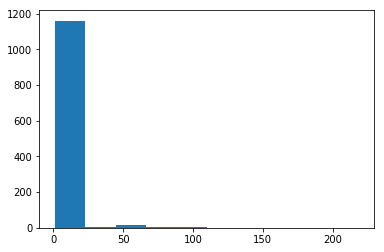

In [40]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G2)

In [94]:
nx.write_gexf(G2, "example3.gexf")

KeyError: <class 'NoneType'>

In [37]:
import numpy
def average_citations(G, mynodes):
    degrees = [G.in_degree(n) for n in mynodes]
    print(numpy.mean(degrees))
    
selected_nodes_citation = [n for n,v in G.nodes(data=True) if v['gen'] == '-1']  
average_citations(G, selected_nodes_citation)

35.58139534883721
